#Gaussian Processes on molecules

## Setup custom stuff for the colab (packages, data)

In [0]:
!rm -rf *
!git clone https://github.com/beangoben/chemistry_ml_colab.git
!mv chemistry_ml_colab/* .
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit
!rm -rf chemistry_ml_colab Miniconda3-latest-Linux-x86_64.sh
!pip install gpflow

Cloning into 'chemistry_ml_colab'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 117 (delta 40), reused 92 (delta 19), pack-reused 0
Receiving objects: 100% (117/117), 8.87 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (40/40), done.
--2019-05-23 12:08:04--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70348401 (67M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  67.09M   141MB/s    in 0.5s    

2019-05-23 12:08:05 (141 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [70348401/70348401]

PREFIX=/usr/local
reinstalling: python-3.7.3-h0371630_0 

In [0]:
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

## Import libraries


In [0]:
from collections import OrderedDict

# tqdm for a progress bar
from tqdm import tqdm
# scientific python stack
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Chemo-informatics
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
print('RDKit:{}'.format(rdkit.__version__))
# ML/DL
import sklearn
import sklearn.model_selection
import sklearn.metrics
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import gpflow 

print('Tensorflow:{}'.format(tf.__version__))
print('Keras:{}'.format(keras.__version__))
print('gpflow:{}'.format(gpflow.__version__))

RDKit:2019.03.2

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Tensorflow:1.13.1
Keras:2.2.4-tf
gpflow:1.3.0


# Task and data: predict solubility (logP) 💧

Datatset source: Delaney's solubility dataset from ESOL:  Estimating Aqueous Solubility Directly from Molecular Structure
(https://pubs.acs.org/doi/10.1021/ci034243x)

 
#### Machine learning and deep learning in a nutshell

![](https://github.com/beangoben/chemistry_ml_colab/blob/master/images/ml_dl.png?raw=true)


## Let's load some molecular data with 🐼s

In [0]:
df = pd.read_csv('data/solubility.csv')
print(df.shape)
print(df.columns)
smiles_column='smiles'
target='measured log solubility in mols per litre'
df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
df.head()

(1128, 10)
Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles,mol
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,<rdkit.Chem.rdchem.Mol object at 0x7f1db5dbd5d0>
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2,<rdkit.Chem.rdchem.Mol object at 0x7f1db5dbd620>
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O),<rdkit.Chem.rdchem.Mol object at 0x7f1db5dbd6c0>
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,<rdkit.Chem.rdchem.Mol object at 0x7f1db5dbd710>
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1,<rdkit.Chem.rdchem.Mol object at 0x7f1db5dbd760>


## Let's prepare our y data and our splits

(1128, 1)
846 282


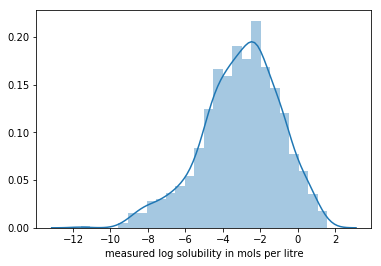

In [0]:
y = df[target].values.reshape(-1,1)
print(y.shape)
indices=df.index.tolist()
train_index,test_index = sklearn.model_selection.train_test_split(indices)
print(len(train_index),len(test_index))

sns.distplot(y)
plt.xlabel(target)
plt.show()

## Molweight to LogP

In [0]:
from gpflow.kernels import RBF
import gpflow as gpf
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

x_feat = StandardScaler().fit_transform(df[['Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area']].values)

x_fp = np.array(df['mol'].apply(Chem.RDKFingerprint).tolist()).astype(float)

x_fp = PCA(200).fit_transform(x_fp)
x = x_fp
print(x_fp.shape)

y = StandardScaler().fit_transform(df[target].values.reshape(-1,1))


x_train, x_test = x[train_index],x[test_index]
y_train, y_test = y[train_index],y[test_index]


#kern = RBF(1,active_dims=[0])+RBF(1,active_dims=[1])+RBF(1,active_dims=[0])*RBF(1,active_dims=[1])
#kern = RBF(1,active_dims=[0])*RBF(1,active_dims=[1])
kern = RBF(x.shape[-1])

gp =  gpflow.models.GPR(x_train,y_train,kern)
gp.as_pandas_table()

(1128, 200)


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,1.0
GPR/kern/variance,Parameter,None,+ve,True,(),True,1.0
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,1.0


In [0]:
#opt = gpf.training.AdamOptimizer()
opt = gpf.training.ScipyOptimizer()
opt.minimize(gp,maxiter=200)
print(gp.compute_log_likelihood())
gp.as_pandas_table()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 753.420149
  Number of iterations: 13
  Number of functions evaluations: 17


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 753.420149
  Number of iterations: 13
  Number of functions evaluations: 17


-753.4201488010409


,class,prior,transform,trainable,shape,fixed_shape,value
GPR/kern/lengthscales,Parameter,None,+ve,True,(),True,8.321553932126655
GPR/kern/variance,Parameter,None,+ve,True,(),True,0.7883625040361127
GPR/likelihood/variance,Parameter,None,+ve,True,(),True,0.13517799787263285


In [0]:
gp.kern.lengthscales.value

array([1.18920806, 1.12580702, 1.12823012, 1.12541239, 1.12694041,
       1.11646419])

In [0]:
-694.2544062829095

In [0]:
y_pred, y_std = gp.predict_f(x_test)
print(r2_score(y_test,y_pred))

0.7715116652913592


In [1]:
mat = kern.compute_K_symm(x_train)
plt.figure(figsize=(12,12))
sns.heatmap(mat)
print(mat.shape)
plt.show()

NameError: ignored